## Catalyst - So many Faces

First of all, let's install the requirements, download the dataset, and import all python dependencies.


### Requirements 
Today we would use Catalyst and Albumentations libraries.
*\
[Catalyst](https://github.com/catalyst-team/catalyst) is the PyTorch framework for Deep Learning research and development. It focuses on reproducibility, rapid experimentation, and codebase reuse so you can create something new rather than write another regular train loop.*


### Dataset 
For the tutorial purpose, we would use [imagewoof2](https://catalyst-team.github.io/catalyst/api/contrib.html#catalyst.contrib.datasets.cv.imagewoof.Imagewoof) classification dataset.
*\
Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds. The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog. Source: [fastai/imagenette](https://github.com/fastai/imagenette#imagewoof).*


### Imports
We need to import all the required PyTorch dependencies and all Catalyst supported Faces implementations for our benchmark tutorial.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U catalyst==20.12 albumentations==0.5.2 &> /dev/null

In [ ]:
!source catalystenv/bin/activate

In [ ]:
%%bash

wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz &> /dev/null
tar zxvf imagewoof2-320.tgz &> /dev/null

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter

# import catalyst.dl as dl
# from catalyst.contrib.nn import (
#     ArcFace,
#     CosFace,
#     AdaCos,
#     SubCenterArcFace,
#     CurricularFace,
#     ArcMarginProduct,
# )
from sklearn.model_selection import train_test_split

import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models import resnet
from tqdm import tqdm 
import torchvision
import torchvision.transforms as T

%load_ext tensorboard

In [4]:
import catalyst.dl as dl
from catalyst.contrib.nn import (
    ArcFace,
    CosFace,
    AdaCos,
    SubCenterArcFace,
    CurricularFace,
    ArcMarginProduct,
)

## Data

Let's prepare PyTorch datasets and dataloaders from the data.

To do this, we need to
- read all images and make train-validation-test split
- prepare the PyTorch `ImagesDataset`
- prepare data augmentation transforms – `get_transforms`
- and combine all above into `DataLoader` – `get_loaders`

In [ ]:
dataset_path = '/content/drive/MyDrive/butterfly-jiggins-dataset/classification-experiments/jiggins_data_resized'
species_list = os.listdir(dataset_path)

species_list

species2index = {species:i for i, species in enumerate(species_list)}
index2species = {i:species for i, species in enumerate(species_list)}
display(species2index, index2species)

In [46]:
n_classes = len(species2index)
n_classes

18

In [ ]:
%%time
# 建立一个dataframe，用来建立数据到标签的关系，方便建立dataset
# 其实使用fastai的from_folder更快的建立databunch，但是这里为了锻炼能力起见，我决定使用原始的方法来构建dataset
# create the dataframe
species_df = pd.DataFrame()
for species in tqdm(os.listdir(dataset_path)):
    species_imgs_path = os.path.join(dataset_path, species)
    for img in os.listdir(species_imgs_path):
        img_file_path = os.path.join(species_imgs_path, img)
        label = species
        dict_species = {'path':img_file_path, 'label':label}
        species_df = species_df.append(pd.Series(dict_species), ignore_index=True)

In [ ]:
%%time
# 建立一个dataframe，用来建立数据到标签的关系，方便建立dataset
# 其实使用fastai的from_folder更快的建立databunch，但是这里为了锻炼能力起见，我决定使用原始的方法来构建dataset
# create the dataframe
test_species_df = pd.DataFrame()
for species in tqdm(os.listdir('/content/drive/MyDrive/butterfly-jiggins-dataset/classification-experiments/test_jiggins_resized/')):
    species_imgs_path = os.path.join('/content/drive/MyDrive/butterfly-jiggins-dataset/classification-experiments/test_jiggins_resized/', species)
    for img in os.listdir(species_imgs_path):
        img_file_path = os.path.join(species_imgs_path, img)
        label = species
        dict_species = {'path':img_file_path, 'label':label}
        test_species_df = test_species_df.append(pd.Series(dict_species), ignore_index=True)

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

display(species_df.head(), f'the length of data is {len(species_df)}')
 
x, y = species_df['path'], species_df['label']

n_splits = 3
Folds = StratifiedKFold(n_splits=n_splits)

train_list = []
for train, val in Folds.split(x, y):
    display(f'the length of train is {len(train)}, the length of val is {len(val)}')
    train_list.append([train, val])

,path,label
0,/content/drive/MyDrive/butterfly-jiggins-datas...,Heliconiusmelpomene_vicina
1,/content/drive/MyDrive/butterfly-jiggins-datas...,Heliconiusmelpomene_vicina
2,/content/drive/MyDrive/butterfly-jiggins-datas...,Heliconiusmelpomene_vicina
3,/content/drive/MyDrive/butterfly-jiggins-datas...,Heliconiusmelpomene_vicina
4,/content/drive/MyDrive/butterfly-jiggins-datas...,Heliconiusmelpomene_vicina


'the length of data is 1990'

'the length of train is 1326, the length of val is 664'

'the length of train is 1327, the length of val is 663'

'the length of train is 1327, the length of val is 663'

In [50]:
height, width = 224, 224
data_transforms = T.Compose([
        T.Resize(136),
        T.CenterCrop(height),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class species_data(Dataset):
    def __init__(self, df=species_df, transform=data_transforms):
        super(species_data, self).__init__()
        self.df = df
        self.transform = transform
        self.c = 100
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path, species = self.df.iloc[index, 1], self.df.iloc[index, 0]
        target = species2index[species]
#         img_data = cv2.imread(img_path)
        img_data = PIL.Image.open(img_path)
#         print(img_data.size)
        data = self.transform(img_data)
#         print(data.size)
        return data, target

In [51]:
train_index_0, val_index_0 = train_list[0]
train_df_0, val_df_0 = species_df.iloc[train_index_0], species_df.iloc[val_index_0]

display(train_df_0.shape, val_df_0.shape)

train_dataset = species_data(df = train_df_0) 
val_dataset = species_data(df = val_df_0)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

(1326, 2)

(664, 2)

In [52]:
test_dataset = species_data(test_species_df) 

batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [14]:
import glob 

ALL_IMAGES=[]

for species in tqdm(os.listdir(dataset_path)):
    species_imgs_path = os.path.join(dataset_path, species)
    for img in os.listdir(species_imgs_path):
        img_file_path = os.path.join(species_imgs_path, img)
        label = species
        ALL_IMAGES.append(img_file_path)

100%|██████████| 20/20 [00:00<00:00, 522.62it/s]


In [ ]:
valid_images = list(val_df_0['path'])
valid_images

In [ ]:
train_targets = [species2index[str(elem).split("/")[7]] for elem in ALL_IMAGES]
train_targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,


In [ ]:
test_images = list(test_species_df['path'])
test_targets = [species2index[str(elem).split("/")[7]] for elem in test_images]
test_targets

In [53]:
'''
classes = []
for elem in Path(ROOT).glob("**/*.JPG"):
    classes.append(str(elem).split("/")[2])

name2class = {name: idx for idx, name in enumerate(sorted(set(classes)))}
class2name = {v: k for k, v in name2class.items()}
n_classes = len(name2class)
print("Number of classes -", n_classes)
'''

train_images = list(train_df_0['path'])
train_targets = [species2index[str(elem).split("/")[7]] for elem in train_images]

valid_images = list(val_df_0['path'])
valid_targets = [species2index[str(elem).split("/")[7]] for elem in valid_images]

test_images = list(test_species_df['path'])
test_targets = [species2index[str(elem).split("/")[7]] for elem in test_images]
'''
_, vis_images, _, vis_targets = train_test_split(
    valid_images, valid_targets,
    test_size=0.25,
    stratify=valid_targets
)
'''
print("Number of train samples -", len(train_images))
print("Number of valid samples -", len(valid_images))
print("Number of test samples - ",len(test_images))
#print("Number of visualization samples -", len(vis_images))

Number of train samples - 1326
Number of valid samples - 664
Number of test samples -  237


In [54]:
def read_image(file):
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def read_sized_image(path, size=(16, 16)):
    img = read_image(path)
    img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
    return img

In [55]:
class ImagesDataset(Dataset):
    def __init__(self, files, targets=None, transforms=None):
        self.files = files
        self.targets = targets
        self.transforms = transforms

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        file = self.files[index]
        img = read_image(str(file))

        if self.transforms is not None:
            img = self.transforms(image=img)["image"]

        if self.targets is None:
            return img
        
        target = self.targets[index]
        return img, target

In [56]:
def get_transforms(dataset: str):
    """Get transforms depends from dataset.

    Args:
        dataset (str): dataset type (train or valid)

    Returns:
        dataset transforms
    """

    if dataset.lower() == "train":
        return albu.Compose([
            albu.Resize(256, 256),
            albu.RandomCrop(224, 224),
            albu.HorizontalFlip(),
            albu.Normalize(),
            ToTensorV2()
        ])
    else:
        return albu.Compose([
            albu.Resize(224, 224),
            albu.Normalize(),
            ToTensorV2()
        ])


def get_loaders(stage: str, train_bs: int = 128, valid_bs: int = 128) -> tuple:
    """Loaders for a stage.

    Args:
        stage: stage name
        train_bs: train loader batch size
        valid_bs: valid loader batch size

    Returns:
        training and validation loader
    """
    
    train_dataset = ImagesDataset(
        train_images, train_targets, get_transforms("train")
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_bs,
        num_workers=1,
        shuffle=True,
        drop_last=True,
    )

    valid_dataset = ImagesDataset(
        valid_images, valid_targets, get_transforms("valid")
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=valid_bs,
        num_workers=1,
        shuffle=False,
        drop_last=False,
    )
    test_dataset = ImagesDataset(
    test_images, test_targets, get_transforms("valid")
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=valid_bs,
        num_workers=1,
        shuffle=False,
        drop_last=False,
    )
    return {
        "train": train_loader,
        "valid": valid_loader,
        "test": test_loader,
    }

## Model

We also need to define the model architecture for our experiments.
As a simple approach, let's use ResNet-based architecture.

In [57]:
class ResNetEncoder(nn.Module):
    def __init__(self, base, ouf_features, bias=True):
        """
        Args:
            base (str): name of resnet to use
            ouf_features (int): number of features to profuce
            bias (bool): use bias term in final linear layer.
                Default is ``True``.
        """
        super().__init__()

        self.base = vars(resnet)[base](pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.output_filter = self.base.fc.in_features
        self.classifier = nn.Linear(self.output_filter, ouf_features, bias=bias)

    def extract_conv_features(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)

        x = self.avg_pool(x)
        return x

    def forward(self, batch):
        x = self.extract_conv_features(batch)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class EncoderWithHead(nn.Module):
    def __init__(self, encoder, head):
        """
        Args:
            encoder (nn.Module): encoder network
            head (nn.Module): head layer
        """
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, images, targets=None) -> torch.tensor:
        features = self.encoder(images)
        if targets is None:
            return features
        outputs = self.head(features, targets)
        return outputs

## Experiment

Now let's define the Experiment run setup:
- the datasets used for the experiment - `get_loaders`
- the run logic and batch handling - `CustomRunner`
- the embeddings preparation logic - `save_embeddings`

In [58]:
import os
from torch import nn, optim
from torch.utils.data import DataLoader
from catalyst import dl, utils

In [59]:
loaders = get_loaders("")
test_dataset = ImagesDataset(
    test_images, test_targets, get_transforms("valid")
)

In [60]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8338287c70>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f8338289d30>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f834bff8610>}

In [61]:
class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):
        # model train/valid step
        features, targets = batch
        logits = self.model(features, targets)

        loss = self.criterion(logits, targets)
        accuracy = (logits.argmax(1) == targets).float().mean().detach().cpu()

        batch_metrics = {
            "loss": loss.item(),
            "accuracy": accuracy.item(),
        }
        self.batch_metrics.update(batch_metrics)

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def predict_batch(self, batch):
        features, _ = batch
        return F.normalize(self.model.encoder(features.to(self.device)))

Plotting embeddings and accuracies

In [63]:
class VisualizeScatter:
    def __init__(self, fig_size=(10, 10), xlabel='X', ylabel='Y', title=None, 
                 size=10, num_classes=18):
        plt.figure(figsize=fig_size)
        plt.grid('true')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        self.colors = ["red", "black", "yellow", "green", "pink",
              "gray", "lightgreen", "orange", "lightblue", "teal", 
              "darkblue", "purple","violet","olive","cyan",
             "plum","magenta","lightpink"
             ]
        self.num_classes = num_classes
        self.size = size
 
    def add_scatters(self, X):
        x = X[:, 0]
        if X.shape[1] == 2:
            y = X[:, 1]
        else:
            y = np.zeros(len(x))
        points_per_class = len(x) // self.num_classes
        st = 0
        end = points_per_class
        for i in range(self.num_classes):
            plt.scatter(x[st:end], y[st:end], 
                c=self.colors[i % len(self.colors)], 
                s=self.size, label = species_list[i])
            st = end
            end = end + points_per_class
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
 
    @staticmethod
    def show_plot():
        plt.show()


In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import PIL

def save_embeddings(
    dataset, encoder, directory, device="cpu", image_size=(64, 64)
):
    """
    Args:
        dataset (torch.utils.data.Dataset): images dataset,
        encoder (torch.nn.Module): encoder network
        directory (str): directory where will be stored predictions
        device (str or torch.device): inference device
        image_size (Tuple[int, int]): image size to use
            for plotting in embedding
    """
    if not os.path.isdir(directory):
        os.makedirs(directory)
    loader = DataLoader(dataset, shuffle=False, batch_size=32, num_workers=1)
    encoder = encoder.to(device)
    encoder = encoder.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = F.normalize(encoder(x))
            output = output.detach().cpu().numpy()
            embeddings.append(output)
            labels.append(torch.max(y))
    embeddings = np.concatenate(embeddings)
    
    '''
    pca = PCA().fit_transform(embeddings)
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    pca[:, 0] = pca[:, 0]
    pca[:, 1] = pca[:, 1]

    #tx = scale_to_01_range(tx)
    #ty = scale_to_01_range(ty)
        
    pca_vis = VisualizeScatter(fig_size=(10, 2), title='PCA Projection')
    pca_vis.add_scatters(pca)
    pca_vis.show_plot()
    
    
    # initialize a matplotlib plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    colors_per_class = [i for i, j in enumerate(species_list)]
    # for every class, we'll add a scatter plot separately
    cmap = cm.get_cmap('tab20')
    for label in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        print(indices)
        # convert the class color to matplotlib format
        color = np.array(colors_per_class[label], dtype=np.float) / 255
        # add a scatter plot with the corresponding color and label
        ax.scatter(tx, ty, c=np.array(cmap(label)).reshape(1, 4), label=label)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # finally, show the plot
    plt.show()
    '''
    # store embeddings
    writer = SummaryWriter(
        logdir=os.path.join(directory, "embeddings"),
        comment="embeddings"
    )
    small_images = np.stack(
        [read_sized_image(name, image_size) for name in dataset.files],
        axis=0
    )
    small_images = small_images.transpose((0, 3, 1, 2)) / 255.0
    small_images = small_images.astype(np.float32)
    metadata=[name.split("/")[7] for name in dataset.files]
    writer.add_embedding(
        embeddings,
        label_img=small_images,
        metadata=metadata
    )
    writer.close()

In [25]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=e9d1beace50eef0a19d78539a8ca0d3a5a1bedc366b3e2a6b7878a9e4f523994
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=a9cc85474f84dc74fd580d15d83a6a012e669e7581f900b2d57774d8032806f7
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [39]:
import umap.umap_ as umap
from sklearn.decomposition import PCA

def plot_embeddings(
    dataset, encoder, directory, device="cpu", image_size=(64, 64)
):
    loader = DataLoader(dataset, shuffle=False, batch_size=32, num_workers=1)
    encoder = encoder.to(device)
    encoder = encoder.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = F.normalize(encoder(x))
            output = output.detach().cpu().numpy()
            embeddings.append(output)
            labels.append(torch.max(y))
    embeddings = np.concatenate(embeddings)
    
    pca = PCA(n_components=2)
    pca.fit(embeddings)
    pca_proj = pca.transform(embeddings)
    pca_proj[:, 0] = pca_proj[:, 0]
    pca_proj[:, 1] = pca_proj[:, 1]

    pca_vis = VisualizeScatter(fig_size=(10, 4), title='PCA 2-D Projection')
    pca_vis.add_scatters(pca_proj)
    pca_vis.show_plot()

    tsne = TSNE(n_components=2, perplexity=2, 
    ).fit_transform(embeddings)
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tsne[:, 0] = tsne[:, 0]
    tsne[:, 1] = tsne[:, 1]

    #tx = scale_to_01_range(tx)
    #ty = scale_to_01_range(ty)
        
    tsne_vis = VisualizeScatter(fig_size=(10, 4), title='t-SNE 2-D Projection')
    tsne_vis.add_scatters(tsne)
    tsne_vis.show_plot()
    
    umap_proj = umap.UMAP(n_components = 2).fit_transform(embeddings)
    umap_proj[:, 0] = umap_proj[:, 0]
    umap_proj[:, 1] = umap_proj[:, 1]
    
    umap_vis = VisualizeScatter(fig_size=(10, 4), title='UMap 2-D Projection')
    umap_vis.add_scatters(umap_proj)
    umap_vis.show_plot()

In [28]:
from catalyst import dl, metrics

def compute_accuracy(dataset, encoder, directory, device="cpu", image_size=(64, 64)):
    total = 0
    correct = 0
    loader = DataLoader(dataset, shuffle=False, batch_size=32, num_workers=1)
    encoder = encoder.to(device)
    encoder = encoder.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = F.normalize(encoder(x))
            output = output.detach().cpu().numpy()
            embeddings.append(output)
            _, preds = torch.max(y.view(1,-1), dim=1)
            total += len(y)
            correct += (preds.cpu() == y).sum()
    embeddings = np.concatenate(embeddings)
    
    return (correct / total).item()

In [29]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 


Now we are ready to run our expriments,
- define typical experiment setup
- select the desired Face head for our model
- and run them all!

## ArcFace

In [30]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Device:  cuda
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA A100-SXM4-40GB
__CUDA Device Total Memory [GB]: 42.481549312


In [74]:
logdir = "/content/drive/MyDrive/resnet_logs/arcface"
num_epochs = 50

encoder = ResNetEncoder("resnet50", 128)
model = EncoderWithHead(
    encoder,
    ArcFace(128, n_classes, s=2**0.5*np.log(n_classes - 1), m=0.25)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5
)
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-3, weight_decay=1e-5
# )
num_classes = 20
runner = CustomRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir = logdir,
    num_epochs=num_epochs,
    main_metric="accuracy",
    minimize_metric=False,
    fp16=False,
    load_best_on_end=True,
    verbose=False,
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



[2023-04-08 23:02:55,922] 
1/50 * Epoch 1 (train): accuracy=0.1555 | loss=3.2184
1/50 * Epoch 1 (valid): accuracy=0.2801 | loss=2.8107
1/50 * Epoch 1 (test): accuracy=0.1983 | loss=3.2758


INFO:metrics_logger:
1/50 * Epoch 1 (train): accuracy=0.1555 | loss=3.2184
1/50 * Epoch 1 (valid): accuracy=0.2801 | loss=2.8107
1/50 * Epoch 1 (test): accuracy=0.1983 | loss=3.2758


[2023-04-08 23:03:09,850] 
2/50 * Epoch 2 (train): accuracy=0.1969 | loss=2.6122
2/50 * Epoch 2 (valid): accuracy=0.1717 | loss=2.4862
2/50 * Epoch 2 (test): accuracy=0.1224 | loss=3.0132


INFO:metrics_logger:
2/50 * Epoch 2 (train): accuracy=0.1969 | loss=2.6122
2/50 * Epoch 2 (valid): accuracy=0.1717 | loss=2.4862
2/50 * Epoch 2 (test): accuracy=0.1224 | loss=3.0132


[2023-04-08 23:03:22,681] 
3/50 * Epoch 3 (train): accuracy=0.3398 | loss=2.2706
3/50 * Epoch 3 (valid): accuracy=0.4684 | loss=2.0889
3/50 * Epoch 3 (test): accuracy=0.3840 | loss=2.6491


INFO:metrics_logger:
3/50 * Epoch 3 (train): accuracy=0.3398 | loss=2.2706
3/50 * Epoch 3 (valid): accuracy=0.4684 | loss=2.0889
3/50 * Epoch 3 (test): accuracy=0.3840 | loss=2.6491


[2023-04-08 23:03:36,573] 
4/50 * Epoch 4 (train): accuracy=0.5867 | loss=1.7295
4/50 * Epoch 4 (valid): accuracy=0.6627 | loss=1.5714
4/50 * Epoch 4 (test): accuracy=0.5443 | loss=2.1562


INFO:metrics_logger:
4/50 * Epoch 4 (train): accuracy=0.5867 | loss=1.7295
4/50 * Epoch 4 (valid): accuracy=0.6627 | loss=1.5714
4/50 * Epoch 4 (test): accuracy=0.5443 | loss=2.1562


[2023-04-08 23:03:52,094] 
5/50 * Epoch 5 (train): accuracy=0.7711 | loss=1.3650
5/50 * Epoch 5 (valid): accuracy=0.7063 | loss=1.4070
5/50 * Epoch 5 (test): accuracy=0.5781 | loss=1.9484


INFO:metrics_logger:
5/50 * Epoch 5 (train): accuracy=0.7711 | loss=1.3650
5/50 * Epoch 5 (valid): accuracy=0.7063 | loss=1.4070
5/50 * Epoch 5 (test): accuracy=0.5781 | loss=1.9484


[2023-04-08 23:04:05,972] 
6/50 * Epoch 6 (train): accuracy=0.8211 | loss=1.1271
6/50 * Epoch 6 (valid): accuracy=0.7696 | loss=1.2030
6/50 * Epoch 6 (test): accuracy=0.6245 | loss=1.7969


INFO:metrics_logger:
6/50 * Epoch 6 (train): accuracy=0.8211 | loss=1.1271
6/50 * Epoch 6 (valid): accuracy=0.7696 | loss=1.2030
6/50 * Epoch 6 (test): accuracy=0.6245 | loss=1.7969


[2023-04-08 23:04:21,696] 
7/50 * Epoch 7 (train): accuracy=0.8328 | loss=1.0111
7/50 * Epoch 7 (valid): accuracy=0.7681 | loss=1.1058
7/50 * Epoch 7 (test): accuracy=0.6371 | loss=1.6451


INFO:metrics_logger:
7/50 * Epoch 7 (train): accuracy=0.8328 | loss=1.0111
7/50 * Epoch 7 (valid): accuracy=0.7681 | loss=1.1058
7/50 * Epoch 7 (test): accuracy=0.6371 | loss=1.6451


[2023-04-08 23:04:34,434] 
8/50 * Epoch 8 (train): accuracy=0.8484 | loss=0.9194
8/50 * Epoch 8 (valid): accuracy=0.7967 | loss=1.0328
8/50 * Epoch 8 (test): accuracy=0.6582 | loss=1.5401


INFO:metrics_logger:
8/50 * Epoch 8 (train): accuracy=0.8484 | loss=0.9194
8/50 * Epoch 8 (valid): accuracy=0.7967 | loss=1.0328
8/50 * Epoch 8 (test): accuracy=0.6582 | loss=1.5401


[2023-04-08 23:04:49,598] 
9/50 * Epoch 9 (train): accuracy=0.8523 | loss=0.8508
9/50 * Epoch 9 (valid): accuracy=0.8012 | loss=0.9882
9/50 * Epoch 9 (test): accuracy=0.6624 | loss=1.4785


INFO:metrics_logger:
9/50 * Epoch 9 (train): accuracy=0.8523 | loss=0.8508
9/50 * Epoch 9 (valid): accuracy=0.8012 | loss=0.9882
9/50 * Epoch 9 (test): accuracy=0.6624 | loss=1.4785


[2023-04-08 23:05:03,363] 
10/50 * Epoch 10 (train): accuracy=0.8711 | loss=0.7970
10/50 * Epoch 10 (valid): accuracy=0.8253 | loss=0.9340
10/50 * Epoch 10 (test): accuracy=0.6667 | loss=1.3853


INFO:metrics_logger:
10/50 * Epoch 10 (train): accuracy=0.8711 | loss=0.7970
10/50 * Epoch 10 (valid): accuracy=0.8253 | loss=0.9340
10/50 * Epoch 10 (test): accuracy=0.6667 | loss=1.3853


[2023-04-08 23:05:17,389] 
11/50 * Epoch 11 (train): accuracy=0.8789 | loss=0.7661
11/50 * Epoch 11 (valid): accuracy=0.8389 | loss=0.8915
11/50 * Epoch 11 (test): accuracy=0.6751 | loss=1.3226


INFO:metrics_logger:
11/50 * Epoch 11 (train): accuracy=0.8789 | loss=0.7661
11/50 * Epoch 11 (valid): accuracy=0.8389 | loss=0.8915
11/50 * Epoch 11 (test): accuracy=0.6751 | loss=1.3226


[2023-04-08 23:05:31,164] 
12/50 * Epoch 12 (train): accuracy=0.9062 | loss=0.7144
12/50 * Epoch 12 (valid): accuracy=0.8479 | loss=0.8606
12/50 * Epoch 12 (test): accuracy=0.6920 | loss=1.2604


INFO:metrics_logger:
12/50 * Epoch 12 (train): accuracy=0.9062 | loss=0.7144
12/50 * Epoch 12 (valid): accuracy=0.8479 | loss=0.8606
12/50 * Epoch 12 (test): accuracy=0.6920 | loss=1.2604


[2023-04-08 23:05:45,063] 
13/50 * Epoch 13 (train): accuracy=0.9227 | loss=0.6831
13/50 * Epoch 13 (valid): accuracy=0.8599 | loss=0.8239
13/50 * Epoch 13 (test): accuracy=0.7004 | loss=1.2080


INFO:metrics_logger:
13/50 * Epoch 13 (train): accuracy=0.9227 | loss=0.6831
13/50 * Epoch 13 (valid): accuracy=0.8599 | loss=0.8239
13/50 * Epoch 13 (test): accuracy=0.7004 | loss=1.2080


[2023-04-08 23:06:00,500] 
14/50 * Epoch 14 (train): accuracy=0.9297 | loss=0.6543
14/50 * Epoch 14 (valid): accuracy=0.8614 | loss=0.7975
14/50 * Epoch 14 (test): accuracy=0.7173 | loss=1.1642


INFO:metrics_logger:
14/50 * Epoch 14 (train): accuracy=0.9297 | loss=0.6543
14/50 * Epoch 14 (valid): accuracy=0.8614 | loss=0.7975
14/50 * Epoch 14 (test): accuracy=0.7173 | loss=1.1642


[2023-04-08 23:06:14,368] 
15/50 * Epoch 15 (train): accuracy=0.9398 | loss=0.6243
15/50 * Epoch 15 (valid): accuracy=0.8750 | loss=0.7656
15/50 * Epoch 15 (test): accuracy=0.7553 | loss=1.1193


INFO:metrics_logger:
15/50 * Epoch 15 (train): accuracy=0.9398 | loss=0.6243
15/50 * Epoch 15 (valid): accuracy=0.8750 | loss=0.7656
15/50 * Epoch 15 (test): accuracy=0.7553 | loss=1.1193


[2023-04-08 23:06:28,859] 
16/50 * Epoch 16 (train): accuracy=0.9492 | loss=0.5979
16/50 * Epoch 16 (valid): accuracy=0.8735 | loss=0.7484
16/50 * Epoch 16 (test): accuracy=0.7637 | loss=1.0610


INFO:metrics_logger:
16/50 * Epoch 16 (train): accuracy=0.9492 | loss=0.5979
16/50 * Epoch 16 (valid): accuracy=0.8735 | loss=0.7484
16/50 * Epoch 16 (test): accuracy=0.7637 | loss=1.0610


[2023-04-08 23:06:41,483] 
17/50 * Epoch 17 (train): accuracy=0.9484 | loss=0.5854
17/50 * Epoch 17 (valid): accuracy=0.8931 | loss=0.7223
17/50 * Epoch 17 (test): accuracy=0.7890 | loss=1.0404


INFO:metrics_logger:
17/50 * Epoch 17 (train): accuracy=0.9484 | loss=0.5854
17/50 * Epoch 17 (valid): accuracy=0.8931 | loss=0.7223
17/50 * Epoch 17 (test): accuracy=0.7890 | loss=1.0404


[2023-04-08 23:06:56,054] 
18/50 * Epoch 18 (train): accuracy=0.9523 | loss=0.5701
18/50 * Epoch 18 (valid): accuracy=0.8916 | loss=0.7123
18/50 * Epoch 18 (test): accuracy=0.7806 | loss=1.0110


INFO:metrics_logger:
18/50 * Epoch 18 (train): accuracy=0.9523 | loss=0.5701
18/50 * Epoch 18 (valid): accuracy=0.8916 | loss=0.7123
18/50 * Epoch 18 (test): accuracy=0.7806 | loss=1.0110


[2023-04-08 23:07:08,964] 
19/50 * Epoch 19 (train): accuracy=0.9570 | loss=0.5450
19/50 * Epoch 19 (valid): accuracy=0.8961 | loss=0.6924
19/50 * Epoch 19 (test): accuracy=0.8059 | loss=0.9779


INFO:metrics_logger:
19/50 * Epoch 19 (train): accuracy=0.9570 | loss=0.5450
19/50 * Epoch 19 (valid): accuracy=0.8961 | loss=0.6924
19/50 * Epoch 19 (test): accuracy=0.8059 | loss=0.9779


[2023-04-08 23:07:24,037] 
20/50 * Epoch 20 (train): accuracy=0.9570 | loss=0.5394
20/50 * Epoch 20 (valid): accuracy=0.8931 | loss=0.6922
20/50 * Epoch 20 (test): accuracy=0.7975 | loss=0.9836


INFO:metrics_logger:
20/50 * Epoch 20 (train): accuracy=0.9570 | loss=0.5394
20/50 * Epoch 20 (valid): accuracy=0.8931 | loss=0.6922
20/50 * Epoch 20 (test): accuracy=0.7975 | loss=0.9836


[2023-04-08 23:07:36,637] 
21/50 * Epoch 21 (train): accuracy=0.9578 | loss=0.5137
21/50 * Epoch 21 (valid): accuracy=0.9051 | loss=0.6655
21/50 * Epoch 21 (test): accuracy=0.8143 | loss=0.9163


INFO:metrics_logger:
21/50 * Epoch 21 (train): accuracy=0.9578 | loss=0.5137
21/50 * Epoch 21 (valid): accuracy=0.9051 | loss=0.6655
21/50 * Epoch 21 (test): accuracy=0.8143 | loss=0.9163


[2023-04-08 23:07:51,140] 
22/50 * Epoch 22 (train): accuracy=0.9633 | loss=0.5119
22/50 * Epoch 22 (valid): accuracy=0.9142 | loss=0.6520
22/50 * Epoch 22 (test): accuracy=0.8228 | loss=0.9108


INFO:metrics_logger:
22/50 * Epoch 22 (train): accuracy=0.9633 | loss=0.5119
22/50 * Epoch 22 (valid): accuracy=0.9142 | loss=0.6520
22/50 * Epoch 22 (test): accuracy=0.8228 | loss=0.9108


[2023-04-08 23:08:06,713] 
23/50 * Epoch 23 (train): accuracy=0.9648 | loss=0.5025
23/50 * Epoch 23 (valid): accuracy=0.9157 | loss=0.6460
23/50 * Epoch 23 (test): accuracy=0.8439 | loss=0.8942


INFO:metrics_logger:
23/50 * Epoch 23 (train): accuracy=0.9648 | loss=0.5025
23/50 * Epoch 23 (valid): accuracy=0.9157 | loss=0.6460
23/50 * Epoch 23 (test): accuracy=0.8439 | loss=0.8942


[2023-04-08 23:08:21,182] 
24/50 * Epoch 24 (train): accuracy=0.9695 | loss=0.4838
24/50 * Epoch 24 (valid): accuracy=0.9172 | loss=0.6382
24/50 * Epoch 24 (test): accuracy=0.8397 | loss=0.8735


INFO:metrics_logger:
24/50 * Epoch 24 (train): accuracy=0.9695 | loss=0.4838
24/50 * Epoch 24 (valid): accuracy=0.9172 | loss=0.6382
24/50 * Epoch 24 (test): accuracy=0.8397 | loss=0.8735


[2023-04-08 23:08:35,978] 
25/50 * Epoch 25 (train): accuracy=0.9727 | loss=0.4821
25/50 * Epoch 25 (valid): accuracy=0.9187 | loss=0.6243
25/50 * Epoch 25 (test): accuracy=0.8439 | loss=0.8481


INFO:metrics_logger:
25/50 * Epoch 25 (train): accuracy=0.9727 | loss=0.4821
25/50 * Epoch 25 (valid): accuracy=0.9187 | loss=0.6243
25/50 * Epoch 25 (test): accuracy=0.8439 | loss=0.8481


[2023-04-08 23:08:49,918] 
26/50 * Epoch 26 (train): accuracy=0.9773 | loss=0.4657
26/50 * Epoch 26 (valid): accuracy=0.9247 | loss=0.6164
26/50 * Epoch 26 (test): accuracy=0.8523 | loss=0.8452


INFO:metrics_logger:
26/50 * Epoch 26 (train): accuracy=0.9773 | loss=0.4657
26/50 * Epoch 26 (valid): accuracy=0.9247 | loss=0.6164
26/50 * Epoch 26 (test): accuracy=0.8523 | loss=0.8452


[2023-04-08 23:09:05,034] 
27/50 * Epoch 27 (train): accuracy=0.9766 | loss=0.4574
27/50 * Epoch 27 (valid): accuracy=0.9262 | loss=0.6010
27/50 * Epoch 27 (test): accuracy=0.8650 | loss=0.8086


INFO:metrics_logger:
27/50 * Epoch 27 (train): accuracy=0.9766 | loss=0.4574
27/50 * Epoch 27 (valid): accuracy=0.9262 | loss=0.6010
27/50 * Epoch 27 (test): accuracy=0.8650 | loss=0.8086


[2023-04-08 23:09:19,141] 
28/50 * Epoch 28 (train): accuracy=0.9773 | loss=0.4511
28/50 * Epoch 28 (valid): accuracy=0.9277 | loss=0.5921
28/50 * Epoch 28 (test): accuracy=0.8650 | loss=0.8050


INFO:metrics_logger:
28/50 * Epoch 28 (train): accuracy=0.9773 | loss=0.4511
28/50 * Epoch 28 (valid): accuracy=0.9277 | loss=0.5921
28/50 * Epoch 28 (test): accuracy=0.8650 | loss=0.8050


[2023-04-08 23:09:34,256] 
29/50 * Epoch 29 (train): accuracy=0.9781 | loss=0.4437
29/50 * Epoch 29 (valid): accuracy=0.9322 | loss=0.5894
29/50 * Epoch 29 (test): accuracy=0.8861 | loss=0.7684


INFO:metrics_logger:
29/50 * Epoch 29 (train): accuracy=0.9781 | loss=0.4437
29/50 * Epoch 29 (valid): accuracy=0.9322 | loss=0.5894
29/50 * Epoch 29 (test): accuracy=0.8861 | loss=0.7684


[2023-04-08 23:09:48,097] 
30/50 * Epoch 30 (train): accuracy=0.9805 | loss=0.4337
30/50 * Epoch 30 (valid): accuracy=0.9322 | loss=0.5844
30/50 * Epoch 30 (test): accuracy=0.8945 | loss=0.7519


INFO:metrics_logger:
30/50 * Epoch 30 (train): accuracy=0.9805 | loss=0.4337
30/50 * Epoch 30 (valid): accuracy=0.9322 | loss=0.5844
30/50 * Epoch 30 (test): accuracy=0.8945 | loss=0.7519


[2023-04-08 23:10:01,514] 
31/50 * Epoch 31 (train): accuracy=0.9812 | loss=0.4263
31/50 * Epoch 31 (valid): accuracy=0.9337 | loss=0.5808
31/50 * Epoch 31 (test): accuracy=0.8903 | loss=0.7492


INFO:metrics_logger:
31/50 * Epoch 31 (train): accuracy=0.9812 | loss=0.4263
31/50 * Epoch 31 (valid): accuracy=0.9337 | loss=0.5808
31/50 * Epoch 31 (test): accuracy=0.8903 | loss=0.7492


[2023-04-08 23:10:15,486] 
32/50 * Epoch 32 (train): accuracy=0.9836 | loss=0.4158
32/50 * Epoch 32 (valid): accuracy=0.9337 | loss=0.5734
32/50 * Epoch 32 (test): accuracy=0.8861 | loss=0.7461


INFO:metrics_logger:
32/50 * Epoch 32 (train): accuracy=0.9836 | loss=0.4158
32/50 * Epoch 32 (valid): accuracy=0.9337 | loss=0.5734
32/50 * Epoch 32 (test): accuracy=0.8861 | loss=0.7461


[2023-04-08 23:10:28,303] 
33/50 * Epoch 33 (train): accuracy=0.9812 | loss=0.4155
33/50 * Epoch 33 (valid): accuracy=0.9337 | loss=0.5690
33/50 * Epoch 33 (test): accuracy=0.8861 | loss=0.7423


INFO:metrics_logger:
33/50 * Epoch 33 (train): accuracy=0.9812 | loss=0.4155
33/50 * Epoch 33 (valid): accuracy=0.9337 | loss=0.5690
33/50 * Epoch 33 (test): accuracy=0.8861 | loss=0.7423


[2023-04-08 23:10:41,151] 
34/50 * Epoch 34 (train): accuracy=0.9820 | loss=0.4120
34/50 * Epoch 34 (valid): accuracy=0.9337 | loss=0.5663
34/50 * Epoch 34 (test): accuracy=0.8903 | loss=0.7326


INFO:metrics_logger:
34/50 * Epoch 34 (train): accuracy=0.9820 | loss=0.4120
34/50 * Epoch 34 (valid): accuracy=0.9337 | loss=0.5663
34/50 * Epoch 34 (test): accuracy=0.8903 | loss=0.7326


[2023-04-08 23:10:54,011] 
35/50 * Epoch 35 (train): accuracy=0.9844 | loss=0.4026
35/50 * Epoch 35 (valid): accuracy=0.9322 | loss=0.5576
35/50 * Epoch 35 (test): accuracy=0.8861 | loss=0.7280


INFO:metrics_logger:
35/50 * Epoch 35 (train): accuracy=0.9844 | loss=0.4026
35/50 * Epoch 35 (valid): accuracy=0.9322 | loss=0.5576
35/50 * Epoch 35 (test): accuracy=0.8861 | loss=0.7280


[2023-04-08 23:11:07,690] 
36/50 * Epoch 36 (train): accuracy=0.9875 | loss=0.4009
36/50 * Epoch 36 (valid): accuracy=0.9352 | loss=0.5491
36/50 * Epoch 36 (test): accuracy=0.8903 | loss=0.7089


INFO:metrics_logger:
36/50 * Epoch 36 (train): accuracy=0.9875 | loss=0.4009
36/50 * Epoch 36 (valid): accuracy=0.9352 | loss=0.5491
36/50 * Epoch 36 (test): accuracy=0.8903 | loss=0.7089


[2023-04-08 23:11:21,740] 
37/50 * Epoch 37 (train): accuracy=0.9852 | loss=0.4001
37/50 * Epoch 37 (valid): accuracy=0.9383 | loss=0.5370
37/50 * Epoch 37 (test): accuracy=0.9198 | loss=0.6721


INFO:metrics_logger:
37/50 * Epoch 37 (train): accuracy=0.9852 | loss=0.4001
37/50 * Epoch 37 (valid): accuracy=0.9383 | loss=0.5370
37/50 * Epoch 37 (test): accuracy=0.9198 | loss=0.6721


[2023-04-08 23:11:35,613] 
38/50 * Epoch 38 (train): accuracy=0.9836 | loss=0.3927
38/50 * Epoch 38 (valid): accuracy=0.9322 | loss=0.5478
38/50 * Epoch 38 (test): accuracy=0.9030 | loss=0.6860


INFO:metrics_logger:
38/50 * Epoch 38 (train): accuracy=0.9836 | loss=0.3927
38/50 * Epoch 38 (valid): accuracy=0.9322 | loss=0.5478
38/50 * Epoch 38 (test): accuracy=0.9030 | loss=0.6860


[2023-04-08 23:11:48,308] 
39/50 * Epoch 39 (train): accuracy=0.9852 | loss=0.3932
39/50 * Epoch 39 (valid): accuracy=0.9337 | loss=0.5453
39/50 * Epoch 39 (test): accuracy=0.9114 | loss=0.6912


INFO:metrics_logger:
39/50 * Epoch 39 (train): accuracy=0.9852 | loss=0.3932
39/50 * Epoch 39 (valid): accuracy=0.9337 | loss=0.5453
39/50 * Epoch 39 (test): accuracy=0.9114 | loss=0.6912


[2023-04-08 23:12:00,991] 
40/50 * Epoch 40 (train): accuracy=0.9859 | loss=0.3803
40/50 * Epoch 40 (valid): accuracy=0.9367 | loss=0.5369
40/50 * Epoch 40 (test): accuracy=0.8945 | loss=0.6958


INFO:metrics_logger:
40/50 * Epoch 40 (train): accuracy=0.9859 | loss=0.3803
40/50 * Epoch 40 (valid): accuracy=0.9367 | loss=0.5369
40/50 * Epoch 40 (test): accuracy=0.8945 | loss=0.6958


[2023-04-08 23:12:15,431] 
41/50 * Epoch 41 (train): accuracy=0.9883 | loss=0.3762
41/50 * Epoch 41 (valid): accuracy=0.9428 | loss=0.5289
41/50 * Epoch 41 (test): accuracy=0.9156 | loss=0.6624


INFO:metrics_logger:
41/50 * Epoch 41 (train): accuracy=0.9883 | loss=0.3762
41/50 * Epoch 41 (valid): accuracy=0.9428 | loss=0.5289
41/50 * Epoch 41 (test): accuracy=0.9156 | loss=0.6624


[2023-04-08 23:12:29,279] 
42/50 * Epoch 42 (train): accuracy=0.9852 | loss=0.3764
42/50 * Epoch 42 (valid): accuracy=0.9398 | loss=0.5196
42/50 * Epoch 42 (test): accuracy=0.9241 | loss=0.6327


INFO:metrics_logger:
42/50 * Epoch 42 (train): accuracy=0.9852 | loss=0.3764
42/50 * Epoch 42 (valid): accuracy=0.9398 | loss=0.5196
42/50 * Epoch 42 (test): accuracy=0.9241 | loss=0.6327


[2023-04-08 23:12:43,271] 
43/50 * Epoch 43 (train): accuracy=0.9891 | loss=0.3661
43/50 * Epoch 43 (valid): accuracy=0.9398 | loss=0.5277
43/50 * Epoch 43 (test): accuracy=0.9114 | loss=0.6664


INFO:metrics_logger:
43/50 * Epoch 43 (train): accuracy=0.9891 | loss=0.3661
43/50 * Epoch 43 (valid): accuracy=0.9398 | loss=0.5277
43/50 * Epoch 43 (test): accuracy=0.9114 | loss=0.6664


[2023-04-08 23:12:56,085] 
44/50 * Epoch 44 (train): accuracy=0.9883 | loss=0.3667
44/50 * Epoch 44 (valid): accuracy=0.9413 | loss=0.5213
44/50 * Epoch 44 (test): accuracy=0.9156 | loss=0.6502


INFO:metrics_logger:
44/50 * Epoch 44 (train): accuracy=0.9883 | loss=0.3667
44/50 * Epoch 44 (valid): accuracy=0.9413 | loss=0.5213
44/50 * Epoch 44 (test): accuracy=0.9156 | loss=0.6502


[2023-04-08 23:13:08,964] 
45/50 * Epoch 45 (train): accuracy=0.9891 | loss=0.3628
45/50 * Epoch 45 (valid): accuracy=0.9367 | loss=0.5180
45/50 * Epoch 45 (test): accuracy=0.9241 | loss=0.6271


INFO:metrics_logger:
45/50 * Epoch 45 (train): accuracy=0.9891 | loss=0.3628
45/50 * Epoch 45 (valid): accuracy=0.9367 | loss=0.5180
45/50 * Epoch 45 (test): accuracy=0.9241 | loss=0.6271


[2023-04-08 23:13:22,277] 
46/50 * Epoch 46 (train): accuracy=0.9875 | loss=0.3626
46/50 * Epoch 46 (valid): accuracy=0.9428 | loss=0.5124
46/50 * Epoch 46 (test): accuracy=0.9156 | loss=0.6405


INFO:metrics_logger:
46/50 * Epoch 46 (train): accuracy=0.9875 | loss=0.3626
46/50 * Epoch 46 (valid): accuracy=0.9428 | loss=0.5124
46/50 * Epoch 46 (test): accuracy=0.9156 | loss=0.6405


[2023-04-08 23:13:34,988] 
47/50 * Epoch 47 (train): accuracy=0.9906 | loss=0.3580
47/50 * Epoch 47 (valid): accuracy=0.9428 | loss=0.5088
47/50 * Epoch 47 (test): accuracy=0.9241 | loss=0.6339


INFO:metrics_logger:
47/50 * Epoch 47 (train): accuracy=0.9906 | loss=0.3580
47/50 * Epoch 47 (valid): accuracy=0.9428 | loss=0.5088
47/50 * Epoch 47 (test): accuracy=0.9241 | loss=0.6339


[2023-04-08 23:13:47,824] 
48/50 * Epoch 48 (train): accuracy=0.9906 | loss=0.3539
48/50 * Epoch 48 (valid): accuracy=0.9398 | loss=0.5080
48/50 * Epoch 48 (test): accuracy=0.9283 | loss=0.6213


INFO:metrics_logger:
48/50 * Epoch 48 (train): accuracy=0.9906 | loss=0.3539
48/50 * Epoch 48 (valid): accuracy=0.9398 | loss=0.5080
48/50 * Epoch 48 (test): accuracy=0.9283 | loss=0.6213


[2023-04-08 23:14:00,612] 
49/50 * Epoch 49 (train): accuracy=0.9891 | loss=0.3524
49/50 * Epoch 49 (valid): accuracy=0.9398 | loss=0.5049
49/50 * Epoch 49 (test): accuracy=0.9241 | loss=0.6148


INFO:metrics_logger:
49/50 * Epoch 49 (train): accuracy=0.9891 | loss=0.3524
49/50 * Epoch 49 (valid): accuracy=0.9398 | loss=0.5049
49/50 * Epoch 49 (test): accuracy=0.9241 | loss=0.6148


[2023-04-08 23:14:13,595] 
50/50 * Epoch 50 (train): accuracy=0.9914 | loss=0.3512
50/50 * Epoch 50 (valid): accuracy=0.9398 | loss=0.5030
50/50 * Epoch 50 (test): accuracy=0.9198 | loss=0.6122


INFO:metrics_logger:
50/50 * Epoch 50 (train): accuracy=0.9914 | loss=0.3512
50/50 * Epoch 50 (valid): accuracy=0.9398 | loss=0.5030
50/50 * Epoch 50 (test): accuracy=0.9198 | loss=0.6122


Top best models:
/content/drive/MyDrive/resnet_logs/arcface/checkpoints/train.41.pth	0.9428
=> Loading checkpoint /content/drive/MyDrive/resnet_logs/arcface/checkpoints/best_full.pth
loaded state checkpoint /content/drive/MyDrive/resnet_logs/arcface/checkpoints/best_full.pth (global epoch 41, epoch 41, stage train)


In [ ]:
runner.model

In [33]:
def load_model(model, model_path):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

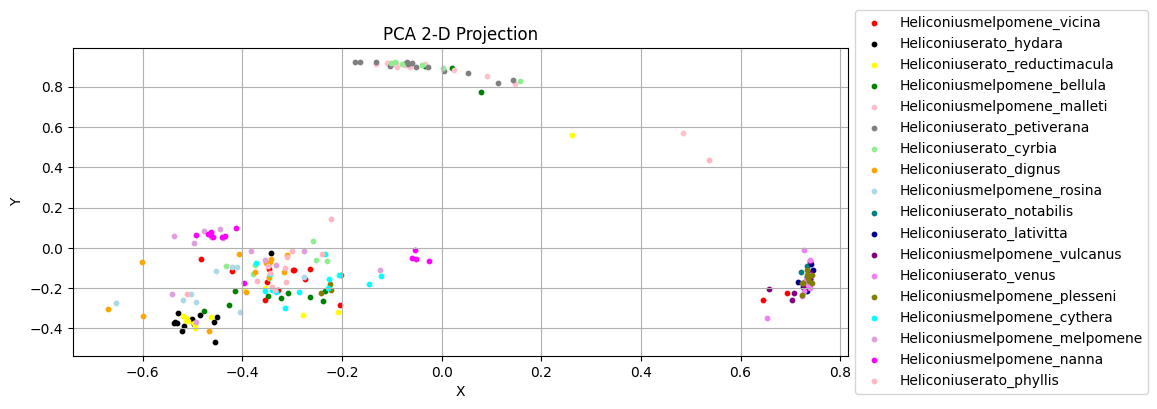

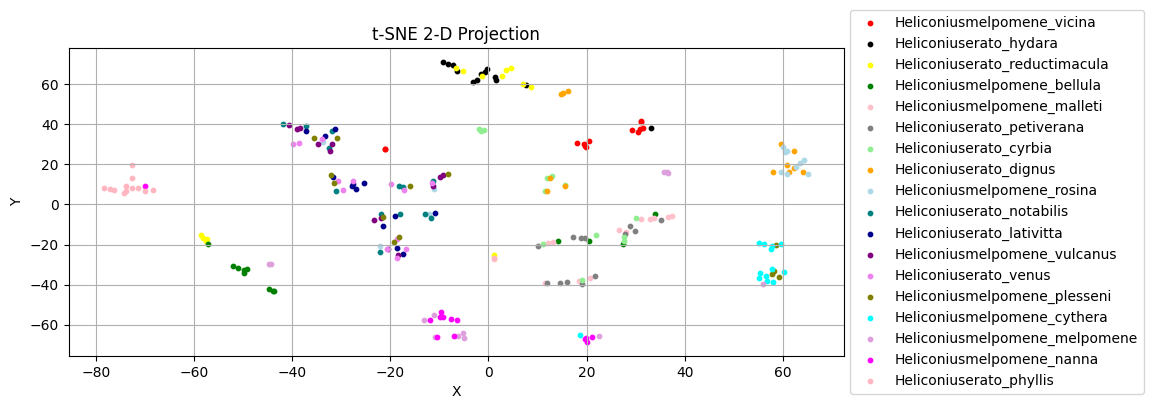

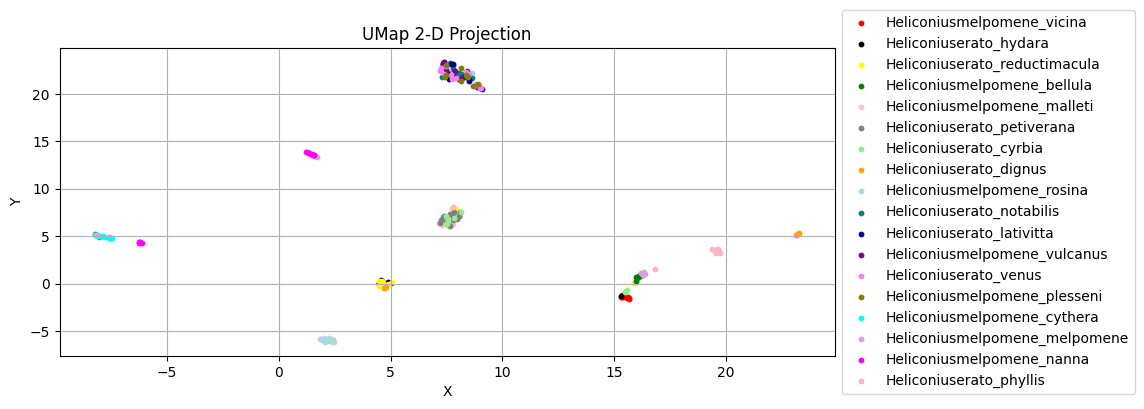

In [77]:
plot_embeddings(test_dataset, runner.model, "arcface", "cuda:0")

In [41]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns

def get_confusion_matrix(
    dataset, encoder, directory, device="cpu", image_size=(64, 64)
):
    loader = DataLoader(dataset, shuffle=False, batch_size=32, num_workers=1)
    encoder = encoder.to(device)
    encoder = encoder.eval()
    embeddings = []
    labels = []
    accuracy_list = []
    preds = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = F.normalize(encoder(x))
            output = output.detach().cpu().numpy()
            embeddings.append(output)
            logits = encoder(x, y)
            preds += list(logits.argmax(1).numpy())
            accuracy = (logits.argmax(1) == y).float().mean().detach().cpu()
            accuracy_list.append(accuracy)
            labels += list(y.numpy())
    embeddings = np.concatenate(embeddings)
    gt = labels
    accuracy_list = [x.item() for x in accuracy_list]
    preds = [class_names[preds[i]] for i in range(len(preds))]
    gt = [class_names[gt[i]] for i in range(len(gt))]
    '''
    cm = confusion_matrix(gt, preds, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=class_names)
    disp.plot()

    plt.show()
    '''
    cm = confusion_matrix(gt, preds)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(24,24))
    sns.heatmap(cmn, annot=True,  xticklabels= class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion matrix.png', dpi = fig.dpi)
    plt.show(block=False)


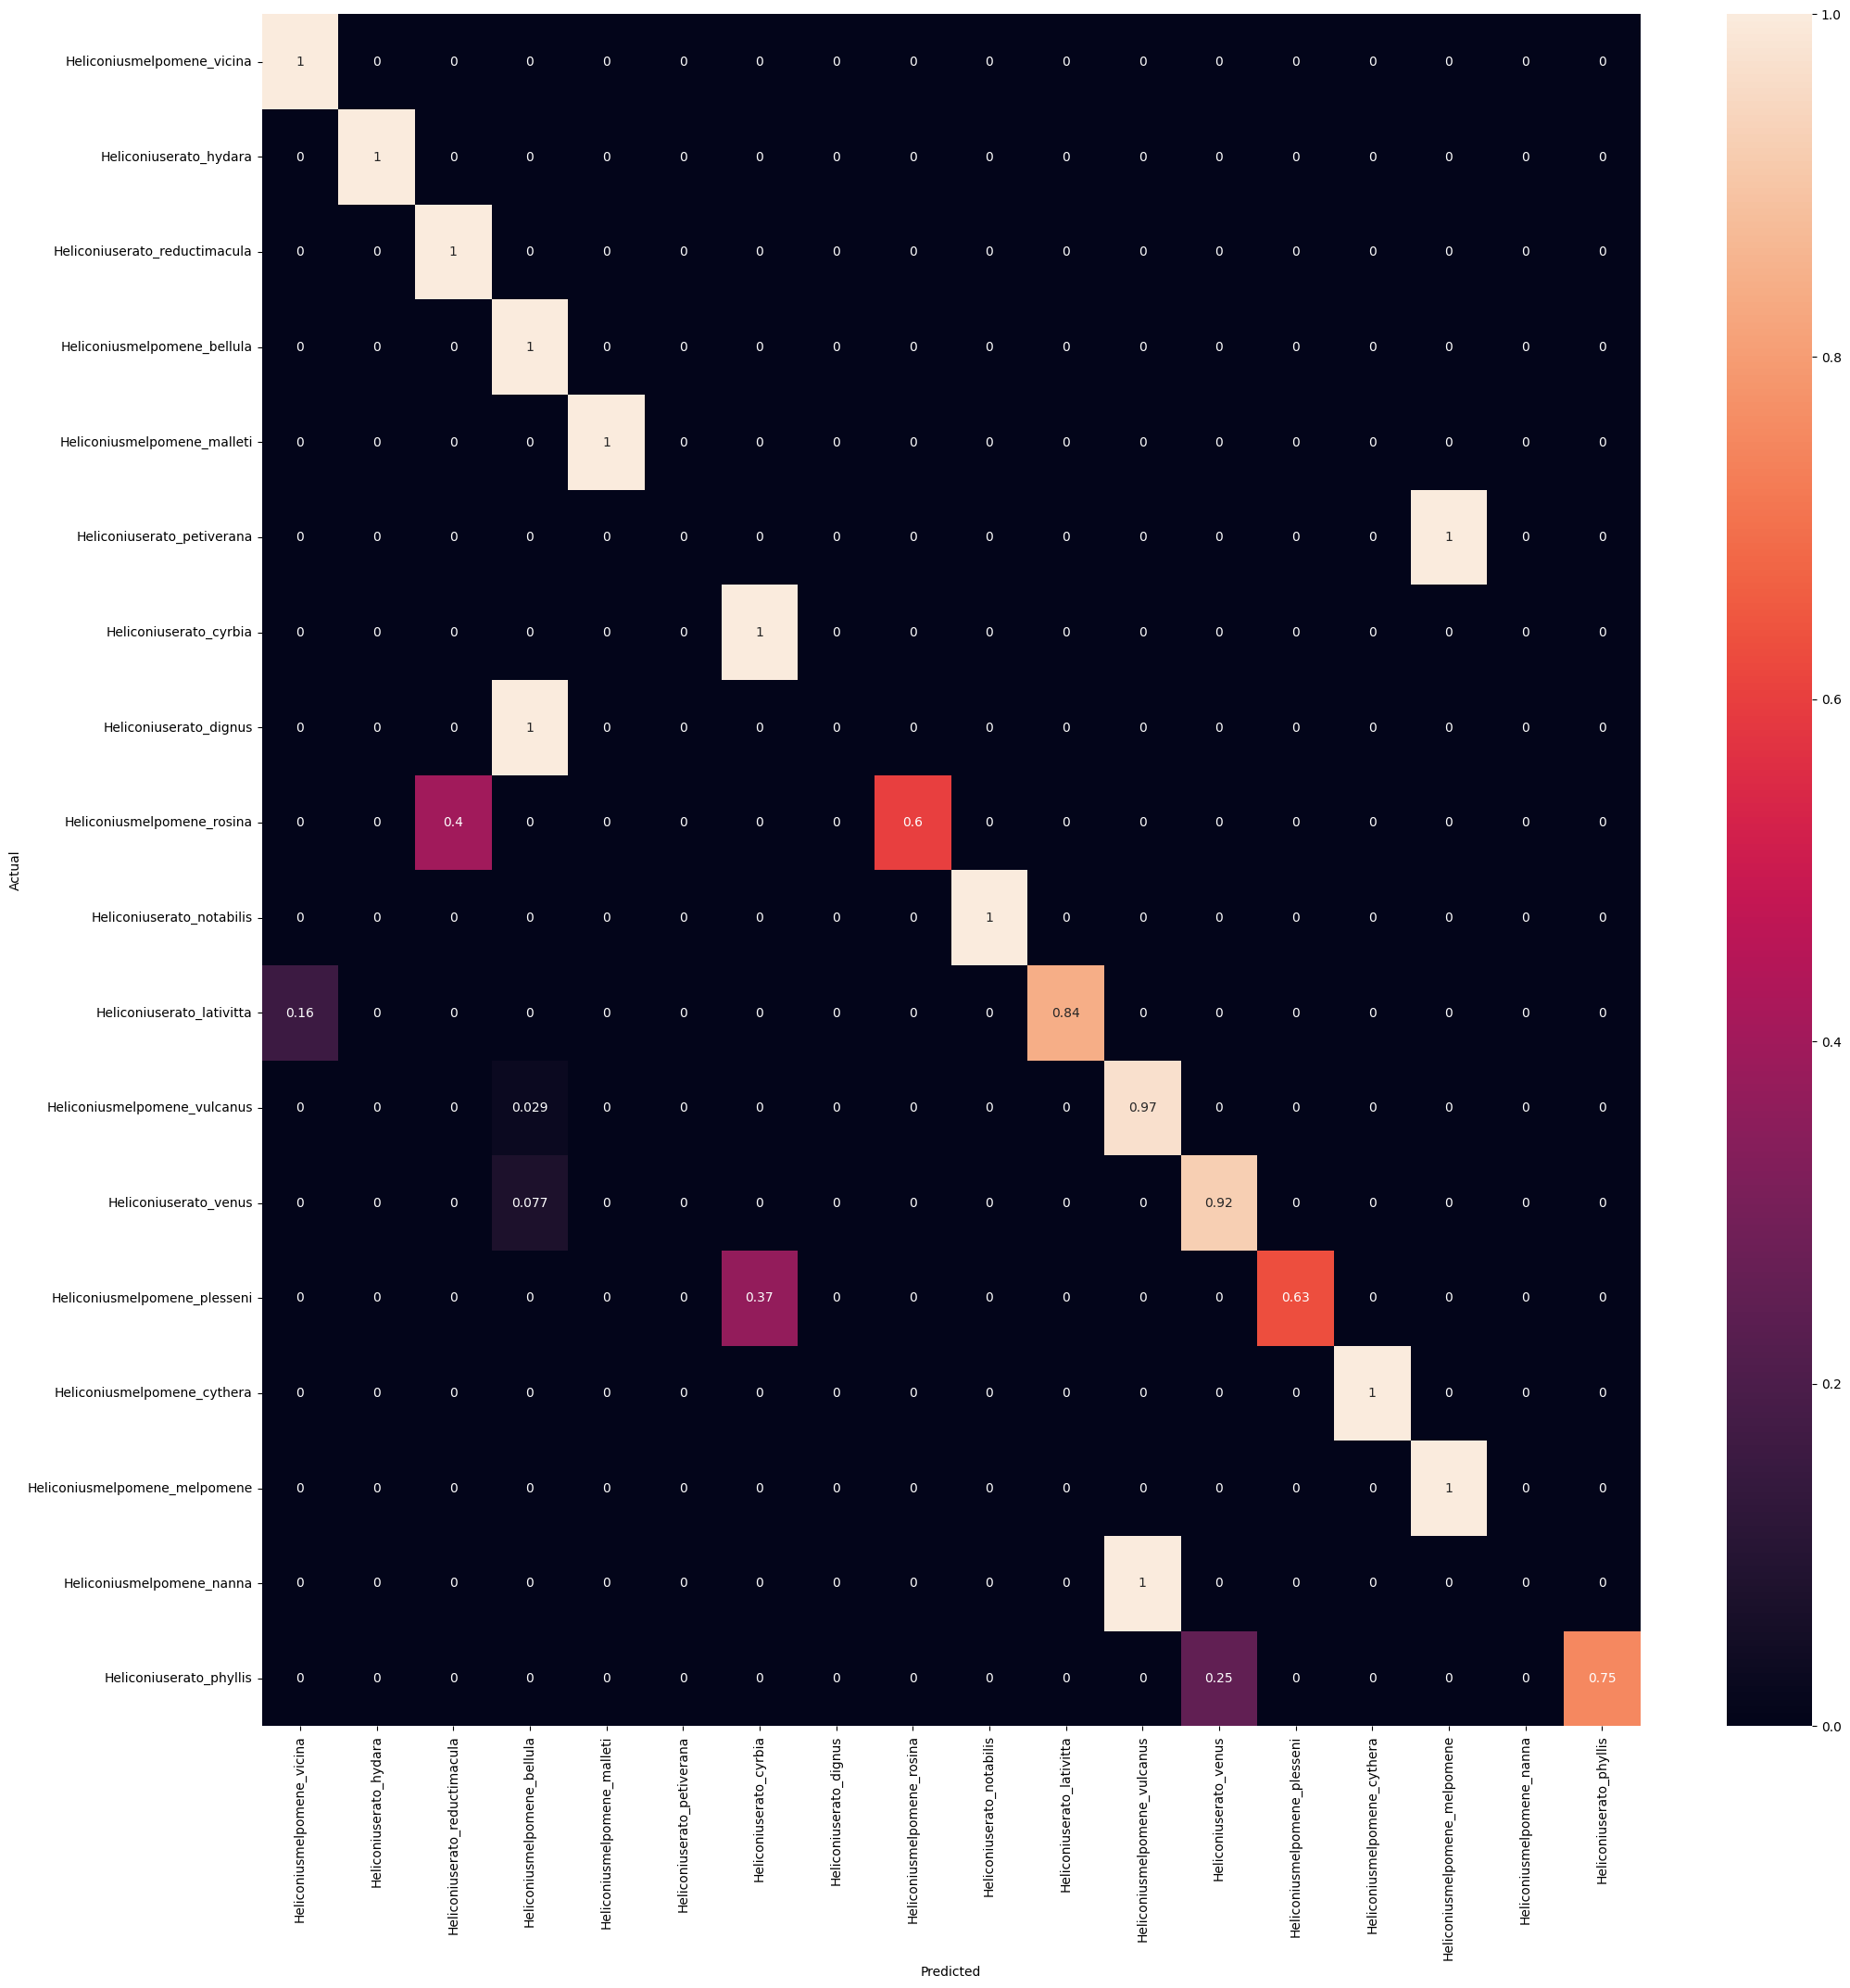

In [78]:
get_confusion_matrix(test_dataset, runner.model, "arcface")

In [ ]:
!pip install catalyst.metrics._metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement catalyst.metrics._metric (from versions: none)
ERROR: No matching distribution found for catalyst.metrics._metric


In [68]:
species_dict = dict((i,j) for i,j in enumerate(species2index))
species = list(species_dict.items())
class_names = [species[i][1] for i in range(len(species))]
class_names

['Heliconiusmelpomene_vicina',
 'Heliconiuserato_hydara',
 'Heliconiuserato_reductimacula',
 'Heliconiusmelpomene_bellula',
 'Heliconiusmelpomene_malleti',
 'Heliconiuserato_petiverana',
 'Heliconiuserato_cyrbia',
 'Heliconiuserato_dignus',
 'Heliconiusmelpomene_rosina',
 'Heliconiuserato_notabilis',
 'Heliconiuserato_lativitta',
 'Heliconiusmelpomene_vulcanus',
 'Heliconiuserato_venus',
 'Heliconiusmelpomene_plesseni',
 'Heliconiusmelpomene_cythera',
 'Heliconiusmelpomene_melpomene',
 'Heliconiusmelpomene_nanna',
 'Heliconiuserato_phyllis']

In [69]:
cnames = [elem.split("Heliconius")[1] for elem in class_names]
cnames

['melpomene_vicina',
 'erato_hydara',
 'erato_reductimacula',
 'melpomene_bellula',
 'melpomene_malleti',
 'erato_petiverana',
 'erato_cyrbia',
 'erato_dignus',
 'melpomene_rosina',
 'erato_notabilis',
 'erato_lativitta',
 'melpomene_vulcanus',
 'erato_venus',
 'melpomene_plesseni',
 'melpomene_cythera',
 'melpomene_melpomene',
 'melpomene_nanna',
 'erato_phyllis']

In [173]:
species2index

{'Heliconiusmelpomene_vicina': 0,
 'Heliconiuserato_hydara': 1,
 'Heliconiuserato_reductimacula': 2,
 'Heliconiusmelpomene_bellula': 3,
 'Heliconiusmelpomene_malleti': 4,
 'Heliconiuserato_petiverana': 5,
 'Heliconiuserato_cyrbia': 6,
 'Heliconiusmelpomene_ecuadorensis': 7,
 'Heliconiuserato_dignus': 8,
 'Heliconiusmelpomene_rosina': 9,
 'Heliconiuserato_notabilis': 10,
 'Heliconius_melpomene': 11,
 'Heliconiuserato_lativitta': 12,
 'Heliconiusmelpomene_vulcanus': 13,
 'Heliconiuserato_venus': 14,
 'Heliconiusmelpomene_plesseni': 15,
 'Heliconiusmelpomene_cythera': 16,
 'Heliconiusmelpomene_melpomene': 17,
 'Heliconiusmelpomene_nanna': 18,
 'Heliconius_erato': 19,
 'Heliconiuserato_etylus': 20,
 'Heliconiuserato_phyllis': 21}

In [ ]:
from typing import Any, List

import numpy as np

import torch

from catalyst.metrics._metric import IMetric
from catalyst.settings import SETTINGS
from catalyst.utils import get_device
from catalyst.utils.distributed import all_gather, get_backend


class ConfusionMatrixMetric(IMetric):
    """Constructs a confusion matrix for a multiclass classification problems.
    Args:
        num_classes: number of classes in the classification problem
        normalize: determines whether or not the confusion matrix is normalize or not
        compute_on_call: Boolean flag to computes
            and return confusion matrix during __call__.
            default: True
    Examples:
    .. code-block:: python
        import torch
        from torch.utils.data import DataLoader, TensorDataset
        from catalyst import dl
        # sample data
        num_samples, num_features, num_classes = int(1e4), int(1e1), 4
        X = torch.rand(num_samples, num_features)
        y = (torch.rand(num_samples,) * num_classes).to(torch.int64)
        # pytorch loaders
        dataset = TensorDataset(X, y)
        loader = DataLoader(dataset, batch_size=32, num_workers=1)
        loaders = {"train": loader, "valid": loader}
        # model, criterion, optimizer, scheduler
        model = torch.nn.Linear(num_features, num_classes)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2])
        # model training
        runner = dl.SupervisedRunner(
            input_key="features",
            output_key="logits",
            target_key="targets",
            loss_key="loss"
        )
        runner.train(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            loaders=loaders,
            logdir="./logdir",
            num_epochs=3,
            valid_loader="valid",
            valid_metric="accuracy03",
            minimize_valid_metric=False,
            verbose=True,
            callbacks=[
                dl.AccuracyCallback(
                    input_key="logits", target_key="targets", num_classes=num_classes
                ),
                dl.PrecisionRecallF1SupportCallback(
                    input_key="logits", target_key="targets", num_classes=num_classes
                ),
                dl.AUCCallback(input_key="logits", target_key="targets"),
                dl.ConfusionMatrixCallback(
                    input_key="logits", target_key="targets", num_classes=num_classes
                ),
            ],
        )
    .. note::
        Please follow the `minimal examples`_ sections for more use cases.
        .. _`minimal examples`: https://github.com/catalyst-team/catalyst#minimal-examples  # noqa: E501, W505
    """

    def __init__(
        self, num_classes: int, normalize: bool = False, compute_on_call: bool = True
    ):
        """Constructs a confusion matrix for a multiclass classification problems."""
        super().__init__(compute_on_call=compute_on_call)
        self.num_classes = num_classes
        self.normalize = normalize
        self.conf = np.ndarray((num_classes, num_classes), dtype=np.int32)
        self._ddp_backend = None
        self.reset()

    def reset(self) -> None:
        """Reset confusion matrix, filling it with zeros."""
        self.conf.fill(0)
        self._ddp_backend = get_backend()

    def update(self, predictions: torch.Tensor, targets: torch.Tensor) -> None:
        """Computes the confusion matrix of ``K x K`` size where ``K`` is no of classes.
        Args:
            predictions: Can be an N x K tensor of predicted scores
                obtained from the model for N examples and K classes
                or an N-tensor of integer values between 0 and K-1
            targets: Can be a N-tensor of integer values assumed
                to be integer values between 0 and K-1 or N x K tensor, where
                targets are assumed to be provided as one-hot vectors
        """
        predictions = predictions.cpu().numpy()
        targets = targets.cpu().numpy()

        assert (
            predictions.shape[0] == targets.shape[0]
        ), "number of targets and predicted outputs do not match"

        if np.ndim(predictions) != 1:
            assert (
                predictions.shape[1] == self.num_classes
            ), "number of predictions does not match size of confusion matrix"
            predictions = np.argmax(predictions, 1)
        else:
            assert (predictions.max() < self.num_classes) and (
                predictions.min() >= 0
            ), "predicted values are not between 1 and k"

        onehot_target = np.ndim(targets) != 1
        if onehot_target:
            assert (
                targets.shape[1] == self.num_classes
            ), "Onehot target does not match size of confusion matrix"
            assert (targets >= 0).all() and (
                targets <= 1
            ).all(), "in one-hot encoding, target values should be 0 or 1"
            assert (targets.sum(1) == 1).all(), "multilabel setting is not supported"
            targets = np.argmax(targets, 1)
        else:
            assert (predictions.max() < self.num_classes) and (
                predictions.min() >= 0
            ), "predicted values are not between 0 and k-1"

        # hack for bincounting 2 arrays together
        x = predictions + self.num_classes * targets
        bincount_2d = np.bincount(x.astype(np.int32), minlength=self.num_classes ** 2)
        assert bincount_2d.size == self.num_classes ** 2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        self.conf += conf

    def compute(self) -> Any:
        """
        Returns:
            Confusion matrix of K rows and K columns, where rows corresponds
            to ground-truth targets and columns corresponds to predicted
            targets.
        """
        # ddp hotfix, could be done better
        # but metric must handle DDP on it's own
        if self._ddp_backend == "xla":
            # if you have "RuntimeError: Aborted: Session XXX is not found" here
            # please, ask Google for a more powerful TPU setup ;)
            device = get_device()
            value = torch.tensor([self.conf], device=device)
            self.conf = xm.all_gather(value).sum(0).cpu().detach().numpy()
        elif self._ddp_backend == "ddp":
            value: List[np.ndarray] = all_gather(self.conf)
            value: np.ndarray = np.sum(np.stack(value, axis=0), axis=0)
            self.conf = value

        if self.normalize:
            conf = self.conf.astype(np.float32)
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        else:
            return self

ImportError: cannot import name 'all_gather'

In [ ]:
!pip install -U catalyst

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 544 kB 7.0 MB/s            
     |████████████████████████████████| 120 kB 106.9 MB/s            
  Attempting uninstall: tensorboardX
    Found existing installation: tensorboardX 2.6
    Not uninstalling tensorboardx at /users/PAS2119/reshmarameshbabu/.local/lib/python3.6/site-packages, outside environment /apps/project/ondemand/app_jupyter/3.1.18
    Can't uninstall 'tensorboardX'. No files were found to uninstall.
  Attempting uninstall: catalyst
    Found existing installation: catalyst 20.12
    Not uninstalling catalyst at /users/PAS2119/reshmarameshbabu/.local/lib/python3.6/site-packages, outside environment /apps/project/ondemand/app_jupyter/3.1.18
    Can't uninstall 'catalyst'. No files were found to uninstall.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
#%tensorboard --logdir arcface
#%load_ext tensorboard
%reload_ext tensorboard
 
%tensorboard --logdir arcface

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Sub-center ArcFace

In [ ]:
logdir = "logs/arcface"
num_epochs = 20

encoder = ResNetEncoder("resnet18", 128)
model = EncoderWithHead(
    encoder,
    SubCenterArcFace(
        128, n_classes, s=2**0.5*np.log(n_classes - 1), m=0.25, k=3
    )
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5
)
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-3, weight_decay=1e-5
# )

runner = CustomRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="accuracy",
    minimize_metric=False,
    fp16=False,
    verbose=False,
    load_best_on_end=True,
)

[2020-12-29 09:34:28,529] 
1/20 * Epoch 1 (train): accuracy=0.0078 | loss=2.7692
1/20 * Epoch 1 (valid): accuracy=0.0954 | loss=2.3841
[2020-12-29 09:34:51,550] 
2/20 * Epoch 2 (train): accuracy=0.4291 | loss=1.9578
2/20 * Epoch 2 (valid): accuracy=0.6343 | loss=1.6349
[2020-12-29 09:35:14,535] 
3/20 * Epoch 3 (train): accuracy=0.6968 | loss=1.4528
3/20 * Epoch 3 (valid): accuracy=0.7432 | loss=1.3271
[2020-12-29 09:35:37,893] 
4/20 * Epoch 4 (train): accuracy=0.7651 | loss=1.2232
4/20 * Epoch 4 (valid): accuracy=0.7788 | loss=1.1737
[2020-12-29 09:36:00,825] 
5/20 * Epoch 5 (train): accuracy=0.8003 | loss=1.0987
5/20 * Epoch 5 (valid): accuracy=0.7956 | loss=1.0819
[2020-12-29 09:36:23,716] 
6/20 * Epoch 6 (train): accuracy=0.8225 | loss=1.0130
6/20 * Epoch 6 (valid): accuracy=0.8127 | loss=1.0171
[2020-12-29 09:36:47,180] 
7/20 * Epoch 7 (train): accuracy=0.8368 | loss=0.9547
7/20 * Epoch 7 (valid): accuracy=0.8262 | loss=0.9680
[2020-12-29 09:37:11,070] 
8/20 * Epoch 8 (train): accu

In [ ]:
save_embeddings(vis_dataset, encoder, "subcenterarcface", "cuda:0")

NameError: name 'vis_dataset' is not defined

In [ ]:
# %tensorboard --logdir subcenterarcface

## ArcMarginProduct

In [ ]:
logdir = "logs/arcmarginproduct"
num_epochs = 20

encoder = ResNetEncoder("resnet18", 128)
model = nn.Sequential(
    encoder,
    ArcMarginProduct(128, n_classes),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5
)
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-3, weight_decay=1e-5
# )

runner = dl.SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="accuracy01",
    minimize_metric=False,
    fp16=False,
    verbose=False,
    load_best_on_end=True,
    callbacks=[dl.AccuracyCallback(num_classes=n_classes)],
)

[2020-12-29 09:50:26,059] 
1/20 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/20 * Epoch 1 (train): accuracy01=0.2247 | accuracy03=0.4644 | accuracy05=0.6455 | loss=2.2725
1/20 * Epoch 1 (valid): accuracy01=0.3332 | accuracy03=0.6119 | accuracy05=0.7615 | loss=2.2432
[2020-12-29 09:50:48,993] 
2/20 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/20 * Epoch 2 (train): accuracy01=0.4592 | accuracy03=0.7279 | accuracy05=0.8461 | loss=2.2085
2/20 * Epoch 2 (valid): accuracy01=0.5780 | accuracy03=0.8190 | accuracy05=0.9030 | loss=2.1698
[2020-12-29 09:51:13,302] 
3/20 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/20 * Epoch 3 (train): accuracy01=0.6635 | accuracy03=0.8655 | accuracy05=0.9251 | loss=2.1228
3/20 * Epoch 3 (valid): accuracy01=0.7279 | accuracy03=0.8974 | accuracy05=0.9504 | loss=2.0717
[2020-12-29 09:51:37,426] 
4/20 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/20 * Epoch 4 (train): accuracy01=0.7800 | accuracy03=0.9256 | accuracy05=0.9680 | loss=2.0183
4/20 * Epoch

In [ ]:
save_embeddings(vis_dataset, encoder, "arcmarginproduct", "cuda:0")

In [ ]:
# %tensorboard --logdir arcmarginproduct

## Classification

In [ ]:
logdir = "logs/classification"
num_epochs = 20

encoder = ResNetEncoder("resnet18", 128)
model = nn.Sequential(
    encoder,
    nn.Linear(128, n_classes),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5
)
# optimizer = optim.Adam(
#     model.parameters(), lr=1e-3, weight_decay=1e-5
# )

runner = dl.SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="accuracy01",
    minimize_metric=False,
    fp16=False,
    verbose=False,
    load_best_on_end=True,
    callbacks=[dl.AccuracyCallback(num_classes=n_classes)],
)

[2020-12-29 10:07:35,042] 
1/20 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/20 * Epoch 1 (train): accuracy01=0.4906 | accuracy03=0.7066 | accuracy05=0.8241 | loss=1.9374
1/20 * Epoch 1 (valid): accuracy01=0.7758 | accuracy03=0.9270 | accuracy05=0.9687 | loss=1.4426
[2020-12-29 10:08:00,519] 
2/20 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/20 * Epoch 2 (train): accuracy01=0.8432 | accuracy03=0.9593 | accuracy05=0.9857 | loss=1.0912
2/20 * Epoch 2 (valid): accuracy01=0.8679 | accuracy03=0.9712 | accuracy05=0.9924 | loss=0.7731
[2020-12-29 10:08:26,828] 
3/20 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/20 * Epoch 3 (train): accuracy01=0.8949 | accuracy03=0.9826 | accuracy05=0.9953 | loss=0.6349
3/20 * Epoch 3 (valid): accuracy01=0.8946 | accuracy03=0.9773 | accuracy05=0.9931 | loss=0.5257
[2020-12-29 10:08:52,764] 
4/20 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/20 * Epoch 4 (train): accuracy01=0.9138 | accuracy03=0.9869 | accuracy05=0.9964 | loss=0.4463
4/20 * Epoch

In [ ]:
save_embeddings(vis_dataset, encoder, "classification", "cuda:0")

In [ ]:
# %tensorboard --logdir classification